# google drive ocr サンプル

In [ ]:
# ライブラリ導入
!pip install  google-api-python-client | tail -1
!pip install google-auth-httplib2 | tail -1
!pip install google-auth-oauthlib | tail -1

In [1]:
# ライブラリインポート Python一般
import io
import os.path
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
#  ライブラリインポート　Google API関係
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build
from googleapiclient.http import MediaFileUpload
from googleapiclient.http import MediaIoBaseDownload

In [3]:
# 変数定義
SCOPES = ['https://www.googleapis.com/auth/drive.file']
MIME_TYPE = 'application/vnd.google-apps.document'
APPLICATION_NAME = 'ipa-google-drive-api-client'

In [4]:
# Google Drive API用サービス取得
def get_service():

    # credentialの取得
    creds = None
    if os.path.exists('token.json'):
        creds = Credentials.from_authorized_user_file('token.json', SCOPES)
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(
                'google-drive-api.json', SCOPES)
            creds = flow.run_local_server(port=0)
        with open('token.json', 'w') as token:
            token.write(creds.to_json())
        
    # serviceの取得
    service = build('drive', 'v3', credentials=creds) 
    
    return service

In [9]:
# イメージからOCR結果を取得
def read_ocr(service, input_file, lang='en'):

    # ファイルのアップロード

    # ローカルファイルの定義
    media_body = MediaFileUpload(input_file, mimetype=MIME_TYPE, resumable=True)

    # Google Drive上のファイル名
    newfile = 'output.pdf'

    body = {
        'name': newfile,
        'mimeType': MIME_TYPE
    }

    # 　creat関数でファイルアップロード実行
    # 同時にOCR読み取りも行う
    output = service.files().create(
        body=body,
        media_body=media_body,
        # ここで読み込み先言語の指定を行う
        ocrLanguage=lang,
    ).execute()

    # テキストファイルのダウンロード

    # リクエストオブジェクト生成
    request = service.files().export_media(
        fileId=output['id'],
        mimeType = "text/plain"
    )

    #  出力用テキストファイル名
    output_path = 'output.txt'

    fh = io.FileIO(output_path, "wb")
    downloader = MediaIoBaseDownload(fh, request)
    done = False
    while done is False:
        status, done = downloader.next_chunk()

    # Google Drive上のファイル削除
    service.files().delete(fileId=output['id']).execute()
 
    # テキストの取得
    with open(output_path) as f:
        mylist = f.read().splitlines()[1:]

    return mylist

In [14]:
# サービスインスタンスの生成
service = get_service()

## 呼び出しサンプル

['', 'This is a pen. That is a book. I like an apple,']


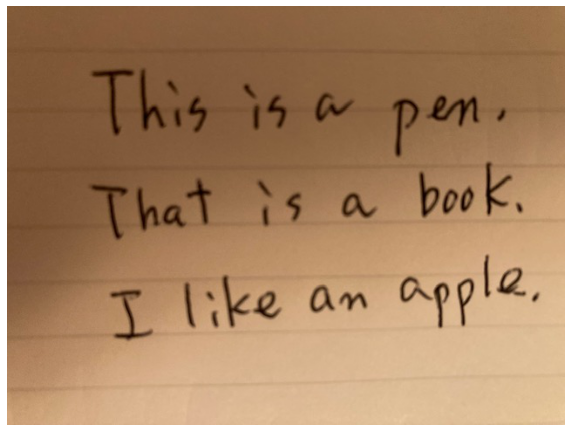

In [16]:
#  　英語の場合

# イメージからOCR読み込み
input_file = 'ocr-sample.jpg'
output = read_ocr(service, input_file)

# 結果確認

# テキストの表示
print(output)

# 元イメージの表示
img = Image.open(input_file)
plt.figure(figsize=(10,10))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

['', '日本語の場合 あかさたな カタカナ']


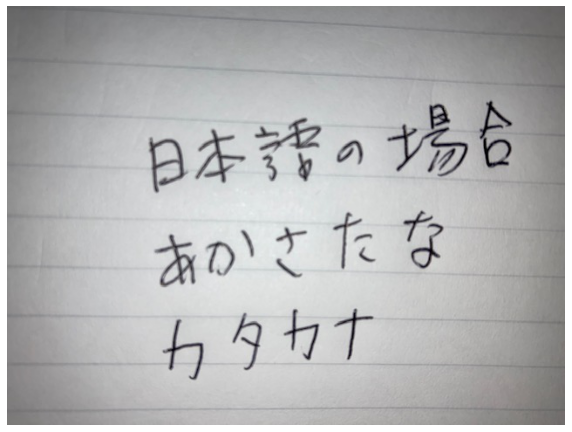

In [17]:
# 日本語の場合

input_file = 'ocr-sample-jp.jpg'
output = read_ocr(service, input_file, 'ja')

# 結果確認

# テキストの表示
print(output)

# 元イメージの表示
img = Image.open(input_file)
plt.figure(figsize=(10,10))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()